# Работа №1 - Поиск ассоциативных правил

_Вариант 5. Сформировать набор из 30 транзакций на основе продуктов, употребляемых на завтрак, обед и ужин._

In [20]:
#! echo '[["Мясо", "Соус", "Вино"],["Мясо", "Соус", "Картофель", "Масло"],["Картофель", "Масло"],["Картофель", "Масло"],["Вино", "Яйца", "Бекон"],["Овощи", "Мясо", "Специи"],["Яйца", "Бекон", "Овощи", "Мясо", "Специи"],["Яйца", "Бекон", "Овощи", "Мясо", "Специи"],["Лапша", "Кетчуп"],["Пельмени", "Майонез", "Кетчуп"],["Пельмени", "Майонез", "Кетчуп"],["Овощи", "Пельмени", "Майонез", "Кетчуп"],["Овощи", "Соус", "Вино"],["Кетчуп"],["Кетчуп", "Лапша", "Пельмени", "Майонез"],["Кетчуп", "Лапша", "Пельмени", "Майонез"],["Кетчуп", "Лапша", "Мясо", "Соус", "Вино"],["Овощи", "Мясо", "Соус", "Вино"],["Майонез"],["Вино"],["Овощи", "Масло"],["Овощи", "Масло", "Картофель"],["Овощи", "Масло", "Картофель", "Мясо", "Соус"],["Овощи", "Бекон", "Яйца"],["Бекон", "Яйца"],["Яйца", "Кетчуп", "Лапша"],["Мясо"],["Мясо", "Масло"],["Мясо", "Масло", "Картофель"],["Масло", "Картофель"]]' > data/data_set.json
#! curl https://raw.githubusercontent.com/viktree/curly-octo-chainsaw/master/BreadBasket_DMS.csv > ./data/BreadBasket_DMS.csv

In [21]:
from lib import datasets
from pandas import pandas
from fpgrowth_py import fpgrowth
from efficient_apriori import apriori as e_apriori
from apriori_python import apriori as apriori

In [22]:
repo_ds = list(map(lambda x: list(x[1]["Item"]), pandas.read_csv("./data/BreadBasket_DMS.csv").groupby(["Transaction"])))
test_ds = datasets.from_json("./data/data_set.json")

## Формирование баз ассоциативных правил

In [23]:
_, test_rules = apriori(test_ds, minSup=0.15, minConf=0.6)
_, repo_rules_60 = apriori(repo_ds, minSup=0.01, minConf=0.6)
_, repo_rules_80 = apriori(repo_ds, minSup=0.01, minConf=0.8)
repo_rules_60

[[{'Toast'}, {'Coffee'}, 0.7044025157232704]]

In [24]:
_, test_rules_e = e_apriori(test_ds, min_support=0.15, min_confidence=0.6)
_, repo_rules_e_60 = e_apriori(repo_ds, min_support=0.01, min_confidence=0.6)
_, repo_rules_e_80 = e_apriori(repo_ds, min_support=0.01, min_confidence=0.8)
list(map(lambda x: (x, x.confidence), repo_rules_e_60))

[({Toast} -> {Coffee}, 0.7044025157232704)]

In [25]:
_, test_rules_fpg = fpgrowth(test_ds, minSupRatio=0.15, minConf=0.6)
_, repo_rules_fpg_60 = fpgrowth(repo_ds, minSupRatio=0.01, minConf=0.6)
_, repo_rules_fpg_80 = fpgrowth(repo_ds, minSupRatio=0.01, minConf=0.8)
repo_rules_fpg_60

[[{'Toast'}, {'Coffee'}, 0.7044025157232704]]

## Ручные расчёты

In [26]:
from lib import associative_rules
r = associative_rules.compute(test_ds)
r[('Соус', 'Вино')]

{'support': 0.13333333333333333,
 'confidence': 0.6666666666666666,
 'significance': 3.96}

## Визуализация правил

In [27]:
from PyARMViz import PyARMViz
# PyARMViz.metadata_scatter_plot(test_rules_e)
# rules = map(lambda x: PyARMViz.Rule(x.lhs, x.rhs), test_rules_e)
rules = test_rules_e
PyARMViz.metadata_scatter_plot(rules)

## Оценка времени формирования

In [28]:
from time import time
def measure(action):
    start = time()
    result = action()
    end = time()
    return end - start, result

confidence_probes = [ x / 10 for x in range(1, 11, 1) ]
algorithms = [
    lambda conf: lambda: fpgrowth(repo_ds, minSupRatio=0.01, minConf=conf),
    lambda conf: lambda: e_apriori(repo_ds, min_support=0.01, min_confidence=conf),
    lambda conf: lambda: apriori(repo_ds, minSup=0.01, minConf=conf)
]
result = {}
for conf in confidence_probes:
    result[conf] = {}
    for n, algorithm in enumerate(algorithms):
        elapsed, _ = measure(algorithm(conf))
        result[conf][n] = elapsed
result

{0.1: {0: 0.5189938545227051, 1: 0.24203944206237793, 2: 0.830005407333374},
 0.2: {0: 0.4894728660583496, 1: 0.2460010051727295, 2: 0.8172051906585693},
 0.3: {0: 0.4939737319946289, 1: 0.24002695083618164, 2: 0.7919633388519287},
 0.4: {0: 0.4579453468322754, 1: 0.2390000820159912, 2: 0.7940278053283691},
 0.5: {0: 0.46399807929992676, 1: 0.2426159381866455, 2: 0.8021934032440186},
 0.6: {0: 0.4609856605529785, 1: 0.24702882766723633, 2: 0.798987865447998},
 0.7: {0: 0.4579932689666748, 1: 0.25199437141418457, 2: 0.8079872131347656},
 0.8: {0: 0.46121978759765625, 1: 0.2430284023284912, 2: 0.801659107208252},
 0.9: {0: 0.4679985046386719, 1: 0.25615501403808594, 2: 0.7937145233154297},
 1.0: {0: 0.45999908447265625, 1: 0.37797021865844727, 2: 0.7911694049835205}}

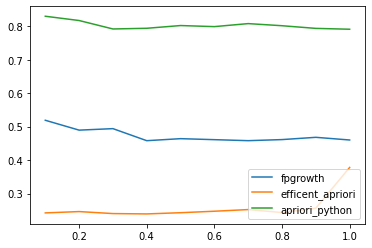

In [29]:
import matplotlib.pyplot as plt
x = confidence_probes
y0 = list(map(lambda conf: result[conf][0] ,result))
y1 = list(map(lambda conf: result[conf][1] ,result))
y2 = list(map(lambda conf: result[conf][2] ,result))
plt.plot(x, y0, label="fpgrowth")
plt.plot(x, y1, label="efficent_apriori")
plt.plot(x, y2, label="apriori_python")
plt.legend()
plt.show()